《[利用Python进行数据分析](https://book.douban.com/subject/25779298/)》读书笔记。
 
 [第11章](/2017/07/24/python_data_analysis11.html)  第3节：更多示例应用

所有用到的数据可以从[作者的 github](https://github.com/wesm/pydata-book)下载。


In [1]:
%pylab inline
import pandas as pd
from pandas import Series, DataFrame

Populating the interactive namespace from numpy and matplotlib


## 信号前沿分析

本小节将介绍一种简化的截面动量投资组合，并得出如何得到模型参数化网格。

In [16]:
# 将几只股票做成一个投资组合，并假装历史价格数据
import pandas_datareader.data as web

names = ['AAPL', 'GOOG', 'MSFT', 'DELL', 'GS', 'MS', 'BAC', 'C']
def get_px(stock, start, end):
    return web.DataReader(stock, 'yahoo',start, end)['Adj Close']
px = DataFrame({n: get_px(n, None, None) for n in names})

#px = pd.read_csv('data/ch11/stock_px.csv')
px.head()

ConnectionError: HTTPConnectionPool(host='ichart.finance.yahoo.com', port=80): Max retries exceeded with url: /table.csv?s=AAPL&a=0&b=1&c=2010&d=6&e=24&f=2017&g=d&ignore=.csv (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x000000000B5C59B0>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed',))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\tseries\index.py:506: UserWarning: Discarding nonzero nanoseconds in conversion
  index = _generate_regular_range(start, end, periods, offset)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


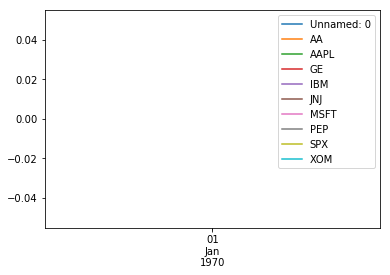

In [4]:
# 绘制每只股票的累计收益
px = px.asfreq('B').fillna(method='pad')
rets = px.pct_change()
((1 + rets).cumprod() - 1).plot()

In [7]:
# 对于投资组合的构建，计算特定回顾期的动量，然后按降序排列，并标准化
def calc_mom(price, lookback, lag):
    mom_ret = price.shift(lag).pct_change(lookback)
    ranks = mom_ret.rank(axis=1, ascending=False)
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0)
    return demeaned.divide(demeaned.std(axis=1), axis=0)

In [8]:
# 编写检验函数，计算夏普比率
compound = lambda x : (1 + x).prod() - 1
daily_sr = lambda x: x.mean() / x.std()

def strat_sr(prices, lb, hold):
    # Compute portfolio weights
    freq = '%dB' % hold
    port = calc_mom(prices, lb, lag=1)

    daily_rets = prices.pct_change()

    # 计算投资组合收益
    port = port.shift(1).resample(freq, how='first')
    returns = daily_rets.resample(freq, how=compound)
    port_rets = (port * returns).sum(axis=1)

    return daily_sr(port_rets) * np.sqrt(252 / hold)

In [11]:
# 得到一个标量值
strat_sr(px, 70, 30)

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [12]:
# 对参数网格（多对参数组合）应用strat_sr函数，结果报出到defaultdict中
# 最后将全部结果放到DataFrame
from collections import defaultdict

lookbacks = range(20, 90, 5)
holdings = range(20, 90, 5)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_sr(px, lb, hold)

ddf = DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [13]:
# 生成热力图

import matplotlib.pyplot as plt

def heatmap(df, cmap=plt.cm.gray_r):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)
heatmap(ddf)    

NameError: name 'ddf' is not defined

## 期货合约转仓

In [17]:
pd.options.display.max_rows = 10

In [21]:
import pandas_datareader.data as web
px = web.DataReader('SPY', 'yahoo')['Adj Close']
#px = web.get_data_yahoo('')['Adj Close'] * 10
px

ConnectionError: HTTPConnectionPool(host='ichart.finance.yahoo.com', port=80): Max retries exceeded with url: /table.csv?s=SPY&a=0&b=1&c=2010&d=6&e=24&f=2017&g=d&ignore=.csv (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x000000000B5E5550>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed',))

In [24]:
# 放入两份标普500指数合约及其到期日
from datetime import datetime
expiry = {'ESU2': datetime(2012, 9, 21),
          'ESZ2': datetime(2012, 12, 21)}
expiry = Series(expiry).order()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: order is deprecated, use sort_values(...)


In [23]:
expiry

ESU2   2012-09-21
ESZ2   2012-12-21
dtype: datetime64[ns]

In [25]:
# 用 雅虎的价格及随机漫步噪声模拟未来走势
np.random.seed(12347)
N = 200
walk = (np.random.randint(0, 200, size=N) - 100) * 0.25
perturb = (np.random.randint(0, 20, size=N) - 10) * 0.25
walk = walk.cumsum()

rng = pd.date_range(px.index[0], periods=len(px) + N, freq='B')
near = np.concatenate([px.values, px.values[-1] + walk])
far = np.concatenate([px.values, px.values[-1] + walk + perturb])
prices = DataFrame({'ESU2': near, 'ESZ2': far}, index=rng)

ValueError: operands could not be broadcast together with shapes (10,) (200,) 

In [26]:
# prices: 关于这两个合约的时间序列
prices.tail()

NameError: name 'prices' is not defined

In [27]:
# 将多个时间序列合并为单个连续序列。方法：构造一个加权矩阵。
# 其中活动合约的权重为1， 直到期满为止。
# 下面的函数计算加权矩阵，权重根据到期前的期数减少而线性衰减

def get_roll_weights(start, expiry, items, roll_periods=5):
    # start : first date to compute weighting DataFrame
    # expiry : Series of ticker -> expiration dates
    # items : sequence of contract names

    dates = pd.date_range(start, expiry[-1], freq='B')
    weights = DataFrame(np.zeros((len(dates), len(items))),
                        index=dates, columns=items)

    prev_date = weights.index[0]
    for i, (item, ex_date) in enumerate(expiry.iteritems()):
        if i < len(expiry) - 1:
            weights.ix[prev_date:ex_date - pd.offsets.BDay(), item] = 1
            roll_rng = pd.date_range(end=ex_date - pd.offsets.BDay(),
                                     periods=roll_periods + 1, freq='B')

            decay_weights = np.linspace(0, 1, roll_periods + 1)
            weights.ix[roll_rng, item] = 1 - decay_weights
            weights.ix[roll_rng, expiry.index[i + 1]] = decay_weights
        else:
            weights.ix[prev_date:, item] = 1

        prev_date = ex_date

    return weights

In [28]:
# 权重计算结果
weights = get_roll_weights('6/1/2012', expiry, prices.columns)
weights.ix['2012-09-12':'2012-09-21']

NameError: name 'prices' is not defined

In [29]:
# 转仓收益就是合约收益的加权和
rolled_returns = (prices.pct_change() * weights).sum(1)

NameError: name 'prices' is not defined

##  移动相关系数与线性回归

动态模型，可用于模拟历史时期中的交易决策。

移动窗口和指数加权时间序列函数是用于处理动态模型的工具。


In [30]:
# 相关系数是观察两个资产时间序列变化的协动性的一种手段。
# pandas 的 rolling_corr函数可以根据两个收益序列，计算出移动窗口的相关系数

# 加载价格序列并计算每日收益率
aapl = web.get_data_yahoo('AAPL', '2000-01-01')['Adj Close']
msft = web.get_data_yahoo('MSFT', '2000-01-01')['Adj Close']

aapl_rets = aapl.pct_change()
msft_rets = msft.pct_change()

ConnectionError: HTTPConnectionPool(host='ichart.finance.yahoo.com', port=80): Max retries exceeded with url: /table.csv?s=AAPL&a=0&b=1&c=2000&d=6&e=24&f=2017&g=d&ignore=.csv (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x000000000B5A6E80>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed',))

In [31]:
# 计算一年期移动相关系数并绘制图表
pd.rolling_corr(aapl_rets, msft_rets, 250).plot()
plt.figure()

NameError: name 'aapl_rets' is not defined

In [32]:
# 两个资产直接的相关系数不能捕获波动性差异。
# 最小二乘回归，提供了一个变量与一个或多个其他预测变量之间动态关系的建模办法
model = pd.ols(y=aapl_rets, x={'MSFT': msft_rets}, window=250)
model.beta

NameError: name 'aapl_rets' is not defined

In [33]:
model.beta['MSFT'].plot()

NameError: name 'model' is not defined